In [16]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re


In [17]:
train_full_df = pd.read_csv("../data/train/meta_fulldf.csv")
test_full_df = pd.read_csv("../data/test/meta_fulldf.csv")

In [18]:
score_columns = ["MSGFScore", "DeNovoScore", "SpecEValue", "EValue"]

In [19]:
# Peptides with mods
# Function that takes dataframe and prints number and percent of unique peptides
def print_unique_peptides(df):
    # Trim before and after the '.' for each peptide
    df['Peptide_Trimmed'] = df['Peptide'].str[2:-2]

    # Print example of trimmed peptide before and after
    # print(df['Peptide'].iloc[0])
    # print(df['Peptide_Trimmed'].iloc[0])
    
    unique_peptides = df['Peptide_Trimmed'].unique()
    print('Number of unique peptides: ' + str(len(unique_peptides)))
    print('Number of total peptides: ' + str(len(df)))
    print('Percent of total peptides: ' + str(round(len(unique_peptides) / len(df) * 100, 3)) + '% are unique')

print('Train:')
print_unique_peptides(train_full_df)
print('\nTest:')
print_unique_peptides(test_full_df)

# Calculate number of peptides overlapping between train and test sets and percent of total
train_peptides = set(train_full_df['Peptide_Trimmed'].unique())
test_peptides = set(test_full_df['Peptide_Trimmed'].unique())
overlap_peptides = train_peptides.intersection(test_peptides)

print('\nNumber of overlapping peptides: ' + str(len(overlap_peptides)))

Train:
Number of unique peptides: 190363
Number of total peptides: 220719
Percent of total peptides: 86.247% are unique

Test:
Number of unique peptides: 162540
Number of total peptides: 192894
Percent of total peptides: 84.264% are unique

Number of overlapping peptides: 4111


In [20]:
# PEptides without mods
# Function that takes dataframe and prints number and percent of unique peptides
def print_unique_peptides(df):
    # Trim before and after the '.' for each peptide
    df['Peptide_Trimmed_unmodified'] = df['peptide_unmodified'].str[2:-2]
    print(df['Peptide_Trimmed_unmodified'].iloc[0])
    
    unique_peptides = df['Peptide_Trimmed_unmodified'].unique()
    print('Number of unique peptides: ' + str(len(unique_peptides)))
    print('Number of total peptides: ' + str(len(df)))
    print('Percent of total peptides: ' + str(round(len(unique_peptides) / len(df) * 100, 3)) + '% are unique')

print('Train:')
print_unique_peptides(train_full_df)
print('\nTest:')
print_unique_peptides(test_full_df)

# Calculate number of peptides overlapping between train and test sets and percent of total
train_peptides = set(train_full_df['Peptide_Trimmed_unmodified'].unique())
test_peptides = set(test_full_df['Peptide_Trimmed_unmodified'].unique())
overlap_peptides = train_peptides.intersection(test_peptides)

print('\nNumber of overlapping peptides: ' + str(len(overlap_peptides)))

Train:
IGYPDDIVSNDNKLNNEYLELNYKEDEYFENIIQNLK
Number of unique peptides: 163357
Number of total peptides: 220719
Percent of total peptides: 74.011% are unique

Test:
AIGGGLSSVGGGSSTIKYTTTSSSSR
Number of unique peptides: 139438
Number of total peptides: 192894
Percent of total peptides: 72.287% are unique

Number of overlapping peptides: 7026


In [21]:
def analyze_score(dataset, score_column, similarity_threshold=0.1):
    true_rows = dataset[dataset['Label'] == True]
    false_rows = dataset[dataset['Label'] == False]

    true_scores = true_rows[score_column]
    false_scores = false_rows[score_column]

    # Calculate summary statistics for dataset
    true_mean_all = round(true_scores.mean(), 3)
    true_std_all = round(true_scores.std(), 3)
    false_mean_all = round(false_scores.mean(), 3)
    false_std_all = round(false_scores.std(), 3)
    print(f"True rows {score_column} mean: {true_mean_all}, std: {true_std_all}")
    print(f"False rows {score_column} mean: {false_mean_all}, std: {false_std_all}")

    # Compare false row scores with their associated true row
    # Select rows within similarity threshold percentage
    true_score_col = "true_" + score_column
    false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])
    close_rows = false_rows[false_rows['score_diff'] <= similarity_threshold]
    print("\nFalse rows with similar " + score_column + " scores to their associated true rows:")
    print("Threshold is " + str(similarity_threshold*100) + "% difference")
    print(len(close_rows), "rows or", round(len(close_rows)/len(false_rows)*100, 2), "% of false rows")

    # Score distribution
    plt.figure()
    plt.hist(true_scores, bins=30, alpha=0.5, label='True rows', color='green')
    plt.hist(false_scores, bins=30, alpha=0.5, label='False rows', color='red')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(score_column + ' Score Distribution')
    plt.show()

    # Compare length of peptide string to scores
    plt.figure()
    plt.scatter(true_rows[score_column], true_rows['peptide_length'], alpha=0.2, label='True rows', color='green', marker='o')
    plt.scatter(false_rows[score_column], false_rows['peptide_length'], alpha=0.2, label='False rows', color='red', marker='x')
    plt.xlabel("Score")
    plt.ylabel("Peptide Length")
    plt.title("Peptide Length vs " + score_column + " Scores")
    plt.show()
    
    # Find average scores for peptides containing modification, e.g. "C+", "M+", "N+"
    modifications = ['C+', 'M+', 'N+', 'Q+']
    for modification in modifications:
        # Get all true and false rows that contain the modification in Peptide name
        true_modification = true_rows[true_rows['Peptide'].str.contains(modification)]
        false_modification = false_rows[false_rows['Peptide'].str.contains(modification)]

        true_mean = round(true_modification[score_column].mean(), 3)
        true_std = round(true_modification[score_column].std(), 3)
        false_mean = round(false_modification[score_column].mean(), 3)
        false_std = round(false_modification[score_column].std(), 3)

        # get diffs in formatted strings
        true_avg_diff = round(true_mean - true_mean_all, 3)
        true_avg_diff = '{0:+}'.format(true_avg_diff)
        false_avg_diff = round(false_mean - false_mean_all, 3)
        false_avg_diff = '{0:+}'.format(false_avg_diff)

        # Print summary statistics
        print("Data for rows containing modification " + modification)
        print(f"    {modification} True rows {score_column} mean: {true_mean} ({true_avg_diff} vs all true rows), std: {true_std}")
        print(f"    {modification} False rows {score_column} mean: {false_mean} ({false_avg_diff} vs all false rows), std: {false_std}")




--TRAINING DATA--
----------------------------------------
Analyzing score column: MSGFScore
True rows MSGFScore mean: 34.273, std: 62.054
False rows MSGFScore mean: 6.24, std: 29.679

False rows with similar MSGFScore scores to their associated true rows:
Threshold is 10.0% difference
14789 rows or 8.94 % of false rows


C:\Users\mcgin\AppData\Local\Temp\ipykernel_25656\3988847154.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


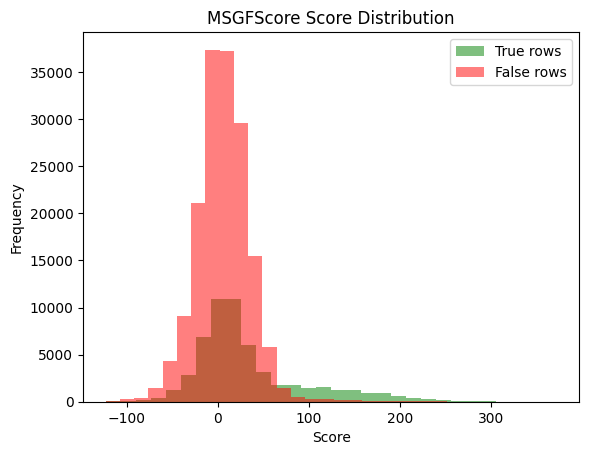

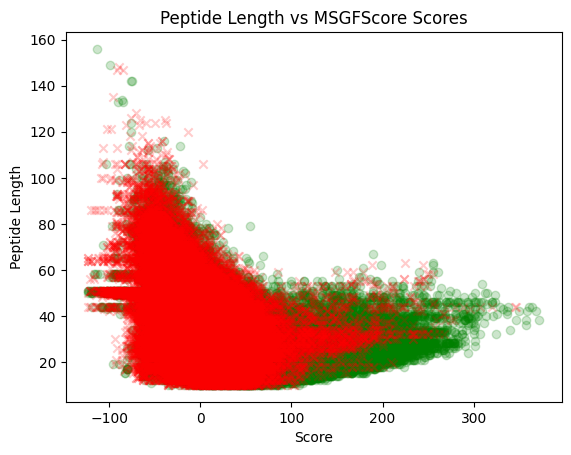

Data for rows containing modification C+
    C+ True rows MSGFScore mean: 16.214 (-18.059 vs all true rows), std: 52.996
    C+ False rows MSGFScore mean: -1.07 (-7.31 vs all false rows), std: 27.724
Data for rows containing modification M+
    M+ True rows MSGFScore mean: 28.799 (-5.474 vs all true rows), std: 60.881
    M+ False rows MSGFScore mean: 3.868 (-2.372 vs all false rows), std: 29.074
Data for rows containing modification N+
    N+ True rows MSGFScore mean: 36.367 (+2.094 vs all true rows), std: 65.854
    N+ False rows MSGFScore mean: 6.561 (+0.321 vs all false rows), std: 30.827
Data for rows containing modification Q+
    Q+ True rows MSGFScore mean: 30.054 (-4.219 vs all true rows), std: 61.402
    Q+ False rows MSGFScore mean: 6.326 (+0.086 vs all false rows), std: 30.34


----------------------------------------
Analyzing score column: DeNovoScore
True rows DeNovoScore mean: 108.987, std: 59.048
False rows DeNovoScore mean: 109.092, std: 59.046

False rows with simila

C:\Users\mcgin\AppData\Local\Temp\ipykernel_25656\3988847154.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


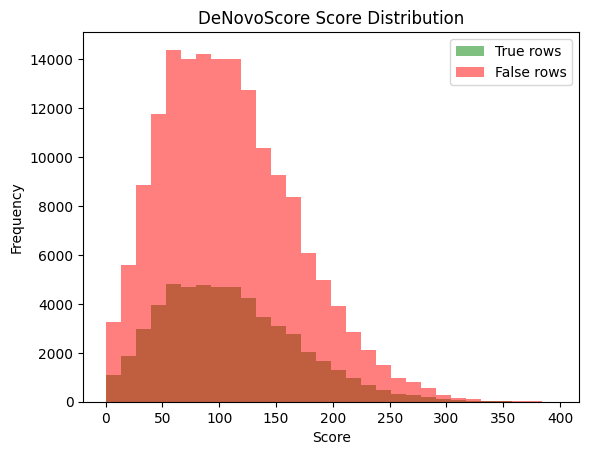

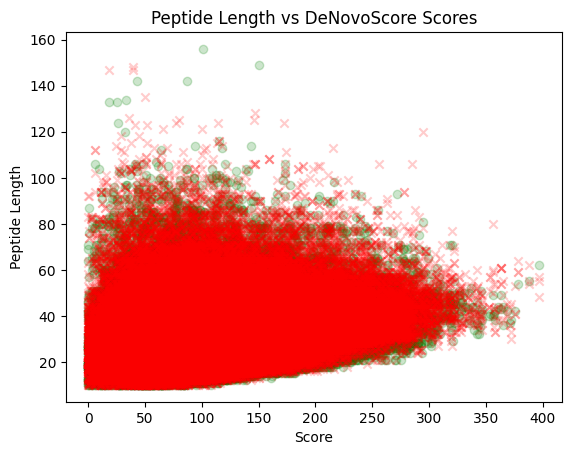

Data for rows containing modification C+
    C+ True rows DeNovoScore mean: 103.999 (-4.988 vs all true rows), std: 59.083
    C+ False rows DeNovoScore mean: 106.816 (-2.276 vs all false rows), std: 58.805
Data for rows containing modification M+
    M+ True rows DeNovoScore mean: 113.728 (+4.741 vs all true rows), std: 60.22
    M+ False rows DeNovoScore mean: 114.893 (+5.801 vs all false rows), std: 59.977
Data for rows containing modification N+
    N+ True rows DeNovoScore mean: 119.095 (+10.108 vs all true rows), std: 60.576
    N+ False rows DeNovoScore mean: 117.664 (+8.572 vs all false rows), std: 59.739
Data for rows containing modification Q+
    Q+ True rows DeNovoScore mean: 114.369 (+5.382 vs all true rows), std: 59.672
    Q+ False rows DeNovoScore mean: 115.968 (+6.876 vs all false rows), std: 59.762


----------------------------------------
Analyzing score column: SpecEValue
True rows SpecEValue mean: 0.002, std: 0.032
False rows SpecEValue mean: 0.003, std: 0.036

Fa

C:\Users\mcgin\AppData\Local\Temp\ipykernel_25656\3988847154.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


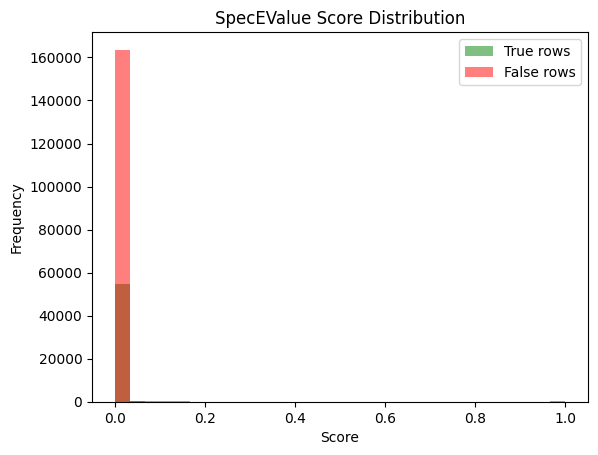

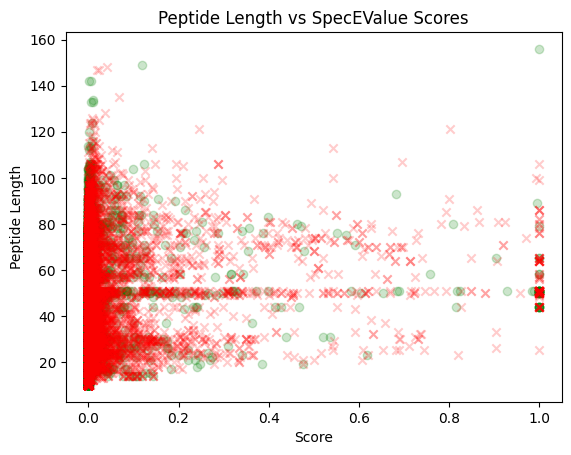

Data for rows containing modification C+
    C+ True rows SpecEValue mean: 0.001 (-0.001 vs all true rows), std: 0.022
    C+ False rows SpecEValue mean: 0.003 (+0.0 vs all false rows), std: 0.034
Data for rows containing modification M+
    M+ True rows SpecEValue mean: 0.002 (+0.0 vs all true rows), std: 0.034
    M+ False rows SpecEValue mean: 0.003 (+0.0 vs all false rows), std: 0.041
Data for rows containing modification N+
    N+ True rows SpecEValue mean: 0.001 (-0.001 vs all true rows), std: 0.019
    N+ False rows SpecEValue mean: 0.001 (-0.002 vs all false rows), std: 0.019
Data for rows containing modification Q+
    Q+ True rows SpecEValue mean: 0.002 (+0.0 vs all true rows), std: 0.033
    Q+ False rows SpecEValue mean: 0.002 (-0.001 vs all false rows), std: 0.035


----------------------------------------
Analyzing score column: EValue
True rows EValue mean: 53239.462, std: 972803.115
False rows EValue mean: 81323.502, std: 1082176.121

False rows with similar EValue scor

C:\Users\mcgin\AppData\Local\Temp\ipykernel_25656\3988847154.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


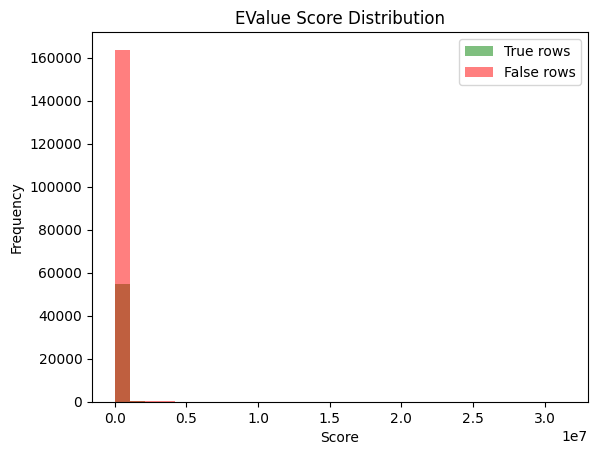

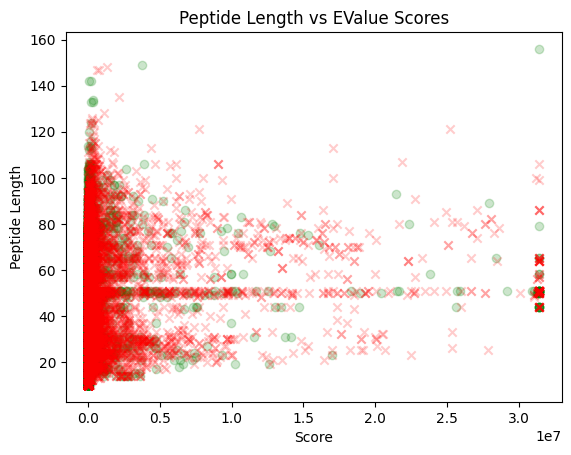

Data for rows containing modification C+
    C+ True rows EValue mean: 37597.84 (-15641.622 vs all true rows), std: 638212.404
    C+ False rows EValue mean: 81783.103 (+459.601 vs all false rows), std: 991240.94
Data for rows containing modification M+
    M+ True rows EValue mean: 59346.631 (+6107.169 vs all true rows), std: 1053423.582
    M+ False rows EValue mean: 90589.309 (+9265.807 vs all false rows), std: 1232335.715
Data for rows containing modification N+
    N+ True rows EValue mean: 22122.679 (-31116.783 vs all true rows), std: 575606.877
    N+ False rows EValue mean: 34982.801 (-46340.701 vs all false rows), std: 566619.78
Data for rows containing modification Q+
    Q+ True rows EValue mean: 51532.257 (-1707.205 vs all true rows), std: 1029304.15
    Q+ False rows EValue mean: 69554.062 (-11769.44 vs all false rows), std: 1085875.458




In [22]:
print("--TRAINING DATA--")
for score_column in score_columns:
        print("----------------------------------------")
        print("Analyzing score column:", score_column)
        analyze_score(train_full_df, score_column, similarity_threshold=0.1)
        print("\n")

--TEST DATA--
----------------------------------------
Analyzing score column: MSGFScore
True rows MSGFScore mean: 34.35, std: 62.744
False rows MSGFScore mean: 5.02, std: 29.479

False rows with similar MSGFScore scores to their associated true rows:
Threshold is 10.0% difference
11669 rows or 8.08 % of false rows


C:\Users\mcgin\AppData\Local\Temp\ipykernel_25656\3988847154.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


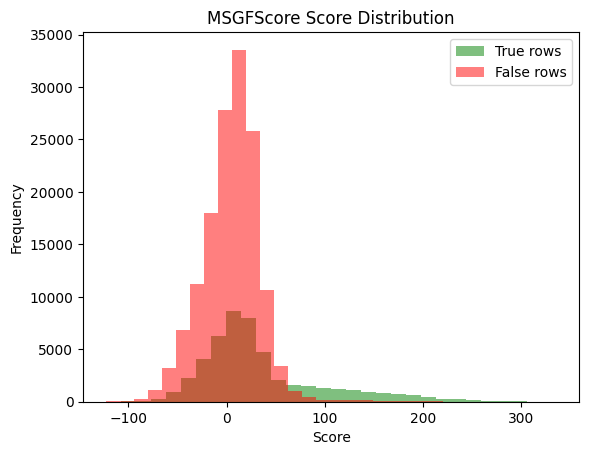

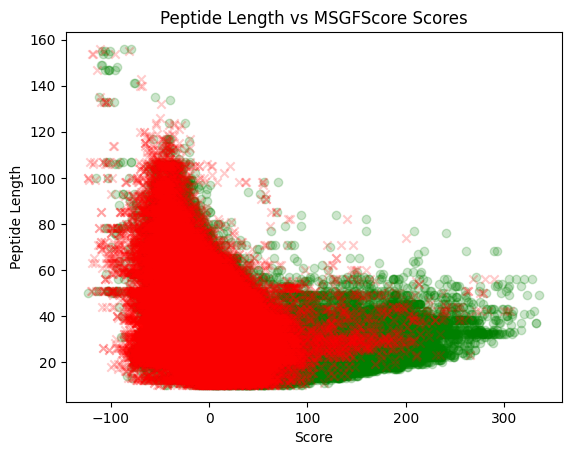

Data for rows containing modification C+
    C+ True rows MSGFScore mean: 19.362 (-14.988 vs all true rows), std: 57.098
    C+ False rows MSGFScore mean: -0.15 (-5.17 vs all false rows), std: 28.043
Data for rows containing modification M+
    M+ True rows MSGFScore mean: 33.609 (-0.741 vs all true rows), std: 62.126
    M+ False rows MSGFScore mean: 5.724 (+0.704 vs all false rows), std: 27.558
Data for rows containing modification N+
    N+ True rows MSGFScore mean: 35.76 (+1.41 vs all true rows), std: 63.311
    N+ False rows MSGFScore mean: 6.922 (+1.902 vs all false rows), std: 28.941
Data for rows containing modification Q+
    Q+ True rows MSGFScore mean: 35.05 (+0.7 vs all true rows), std: 64.37
    Q+ False rows MSGFScore mean: 6.953 (+1.933 vs all false rows), std: 29.128


----------------------------------------
Analyzing score column: DeNovoScore
True rows DeNovoScore mean: 114.771, std: 60.244
False rows DeNovoScore mean: 115.049, std: 60.258

False rows with similar DeN

C:\Users\mcgin\AppData\Local\Temp\ipykernel_25656\3988847154.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


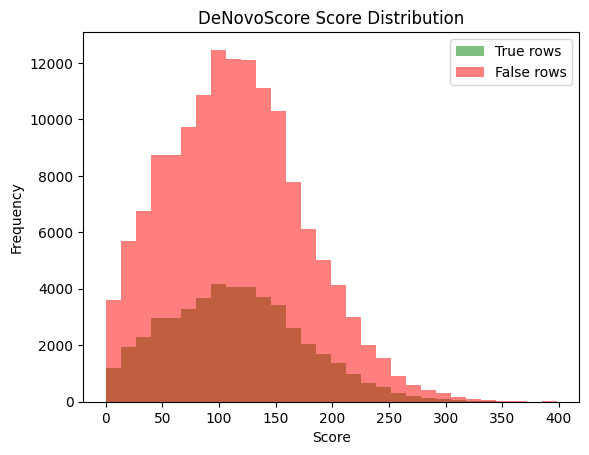

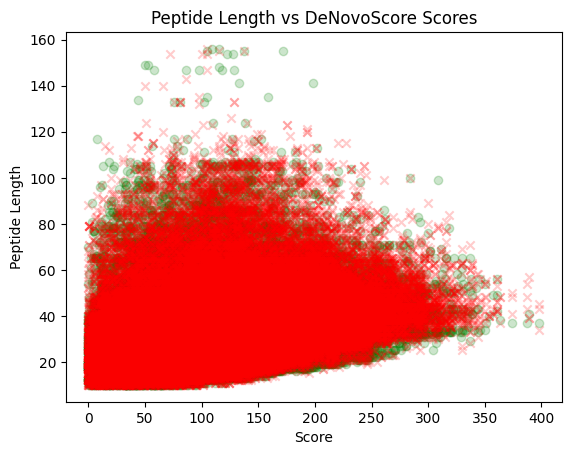

Data for rows containing modification C+
    C+ True rows DeNovoScore mean: 115.619 (+0.848 vs all true rows), std: 62.015
    C+ False rows DeNovoScore mean: 118.664 (+3.615 vs all false rows), std: 61.321
Data for rows containing modification M+
    M+ True rows DeNovoScore mean: 122.974 (+8.203 vs all true rows), std: 60.303
    M+ False rows DeNovoScore mean: 124.654 (+9.605 vs all false rows), std: 60.833
Data for rows containing modification N+
    N+ True rows DeNovoScore mean: 126.445 (+11.674 vs all true rows), std: 60.715
    N+ False rows DeNovoScore mean: 126.46 (+11.411 vs all false rows), std: 60.21
Data for rows containing modification Q+
    Q+ True rows DeNovoScore mean: 124.457 (+9.686 vs all true rows), std: 61.092
    Q+ False rows DeNovoScore mean: 124.69 (+9.641 vs all false rows), std: 60.301


----------------------------------------
Analyzing score column: SpecEValue
True rows SpecEValue mean: 0.003, std: 0.029
False rows SpecEValue mean: 0.006, std: 0.044

Fal

C:\Users\mcgin\AppData\Local\Temp\ipykernel_25656\3988847154.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


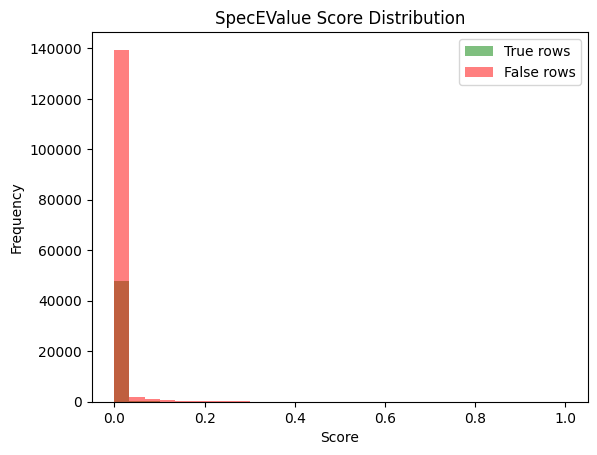

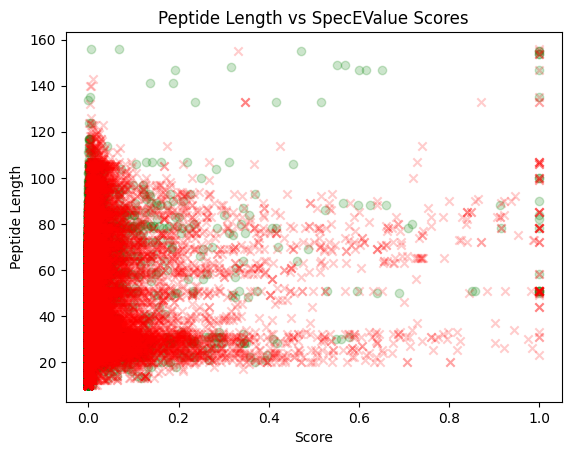

Data for rows containing modification C+
    C+ True rows SpecEValue mean: 0.004 (+0.001 vs all true rows), std: 0.036
    C+ False rows SpecEValue mean: 0.007 (+0.001 vs all false rows), std: 0.049
Data for rows containing modification M+
    M+ True rows SpecEValue mean: 0.003 (+0.0 vs all true rows), std: 0.034
    M+ False rows SpecEValue mean: 0.005 (-0.001 vs all false rows), std: 0.044
Data for rows containing modification N+
    N+ True rows SpecEValue mean: 0.002 (-0.001 vs all true rows), std: 0.026
    N+ False rows SpecEValue mean: 0.003 (-0.003 vs all false rows), std: 0.031
Data for rows containing modification Q+
    Q+ True rows SpecEValue mean: 0.002 (-0.001 vs all true rows), std: 0.028
    Q+ False rows SpecEValue mean: 0.003 (-0.003 vs all false rows), std: 0.033


----------------------------------------
Analyzing score column: EValue
True rows EValue mean: 79285.835, std: 869918.907
False rows EValue mean: 169017.826, std: 1245629.565

False rows with similar EVal

C:\Users\mcgin\AppData\Local\Temp\ipykernel_25656\3988847154.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_rows['score_diff'] = np.abs((false_rows[score_column] - false_rows[true_score_col]) / false_rows[true_score_col])


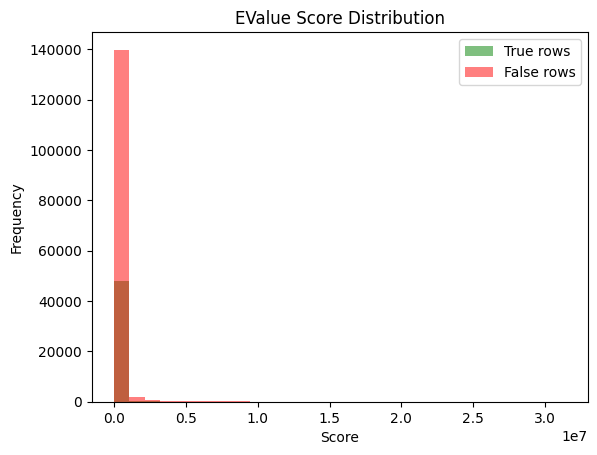

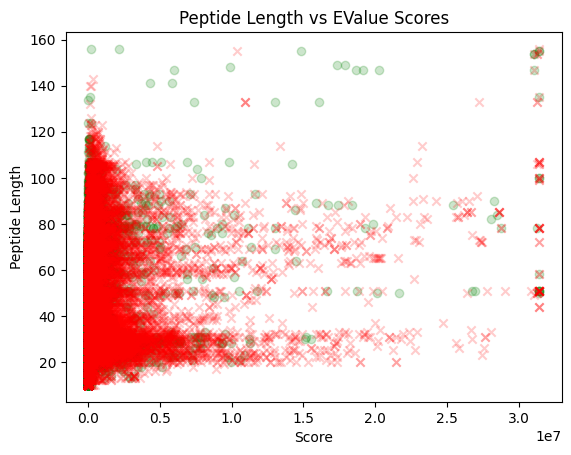

Data for rows containing modification C+
    C+ True rows EValue mean: 107420.426 (+28134.591 vs all true rows), std: 1055781.808
    C+ False rows EValue mean: 196508.783 (+27490.957 vs all false rows), std: 1395869.593
Data for rows containing modification M+
    M+ True rows EValue mean: 77886.305 (-1399.53 vs all true rows), std: 1015630.519
    M+ False rows EValue mean: 136658.897 (-32358.929 vs all false rows), std: 1280193.57
Data for rows containing modification N+
    N+ True rows EValue mean: 52323.484 (-26962.351 vs all true rows), std: 789855.189
    N+ False rows EValue mean: 90975.3 (-78042.526 vs all false rows), std: 938942.336
Data for rows containing modification Q+
    Q+ True rows EValue mean: 57257.074 (-22028.761 vs all true rows), std: 874710.474
    Q+ False rows EValue mean: 99729.479 (-69288.347 vs all false rows), std: 1002749.696




In [23]:
print("--TEST DATA--")
for score_column in score_columns:
        print("----------------------------------------")
        print("Analyzing score column:", score_column)
        analyze_score(test_full_df, score_column, similarity_threshold=0.1)
        print("\n")